In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
test_table = pd.read_csv("Data/02_spanish_translation_AB_test/test_table.csv")
user_table = pd.read_csv("Data/02_spanish_translation_AB_test/user_table.csv")

In [3]:
test_table.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [53]:
print(test_table.shape)

(453321, 9)


In [4]:
user_table.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [56]:
test_table_user = set(test_table["user_id"])
user_table_user = set(user_table["user_id"])

print(f"There are {len(test_table_user - user_table_user)} users missing in user_table")
print(f"There are {len(user_table_user - test_table_user)} users not in test_table")

There are 454 users missing in user_table
There are 0 users not in test_table


In [57]:
data = test_table.merge(user_table, on="user_id")

# Hypothesis test

- H0: the conversion rates are different between the control group and the test group
- H1: the conversion rate of the control group is different with the conversion rate of the test group

Text(0.5, 1.0, 'The number of converted users v.s. non-converted users')

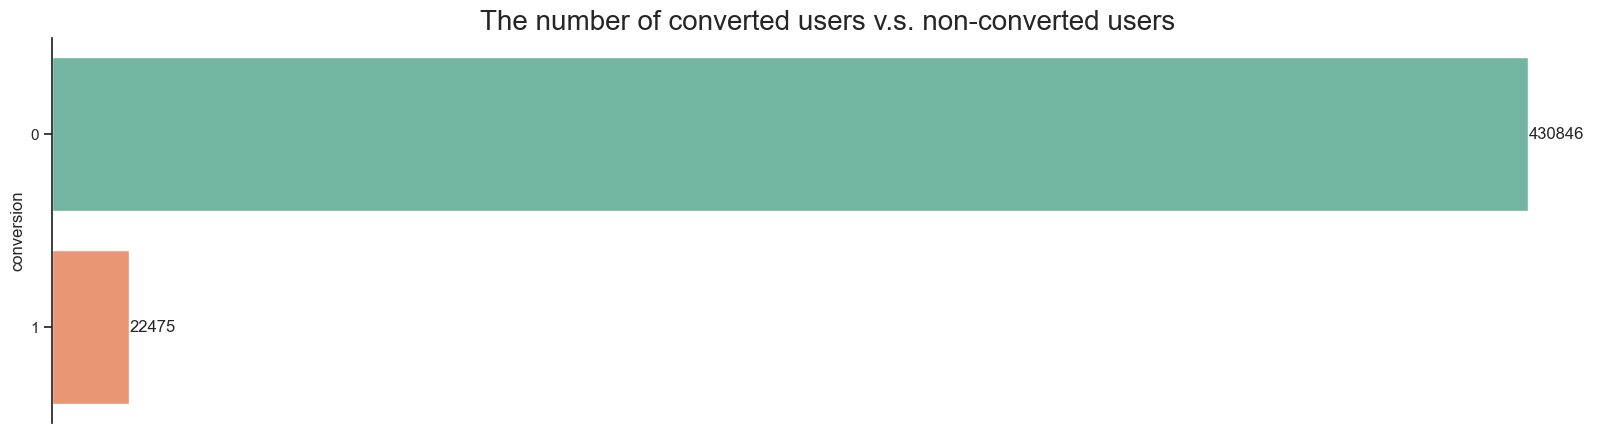

In [6]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.bottom": False, 'xtick.bottom': False}
sns.set_theme(style="ticks", palette="Set2", rc=custom_params)

plt.figure(figsize=(20,5))
ax = sns.countplot(y=test_table["conversion"])
ax.bar_label(ax.containers[0])
ax.set(xticklabels=[])
ax.set(xlabel=None)
plt.title("The number of converted users v.s. non-converted users", fontsize=20)

In [10]:
def plot_conversion_rate_categorical(df, target):
    
    custom_params = {"axes.spines.top": False, "font.size": 16}
    sns.set_theme(style="ticks", palette="Set2", font_scale=2, rc=custom_params)

    # calculate the conversion rate for each target of interest
    group = df[[target, "conversion"]].groupby(target).mean().reset_index()
    order_list = group[target]

    fig, g1 = plt.subplots(figsize=(20, 6))
    g2 = g1.twinx()

    # barplot
    sns.countplot(df, x=target, hue="conversion", order=order_list, ax=g1)
    g1.set_yscale("log")

    # lineplot
    g2.plot(group[target], group["conversion"], color="dimgrey", marker='o', linestyle='dashed',
         linewidth=2, markersize=8)

    # annotation
    for i in range(group.shape[0]):

        x = group.iloc[i][target]
        y = group.iloc[i]["conversion"]
        label = f"{y*100:.2f}%"

        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center', color="dimgrey")
    
    plt.title(f"Conversion rate by {target} group", fontsize=25, pad=40)
    plt.tight_layout()
    plt.show()

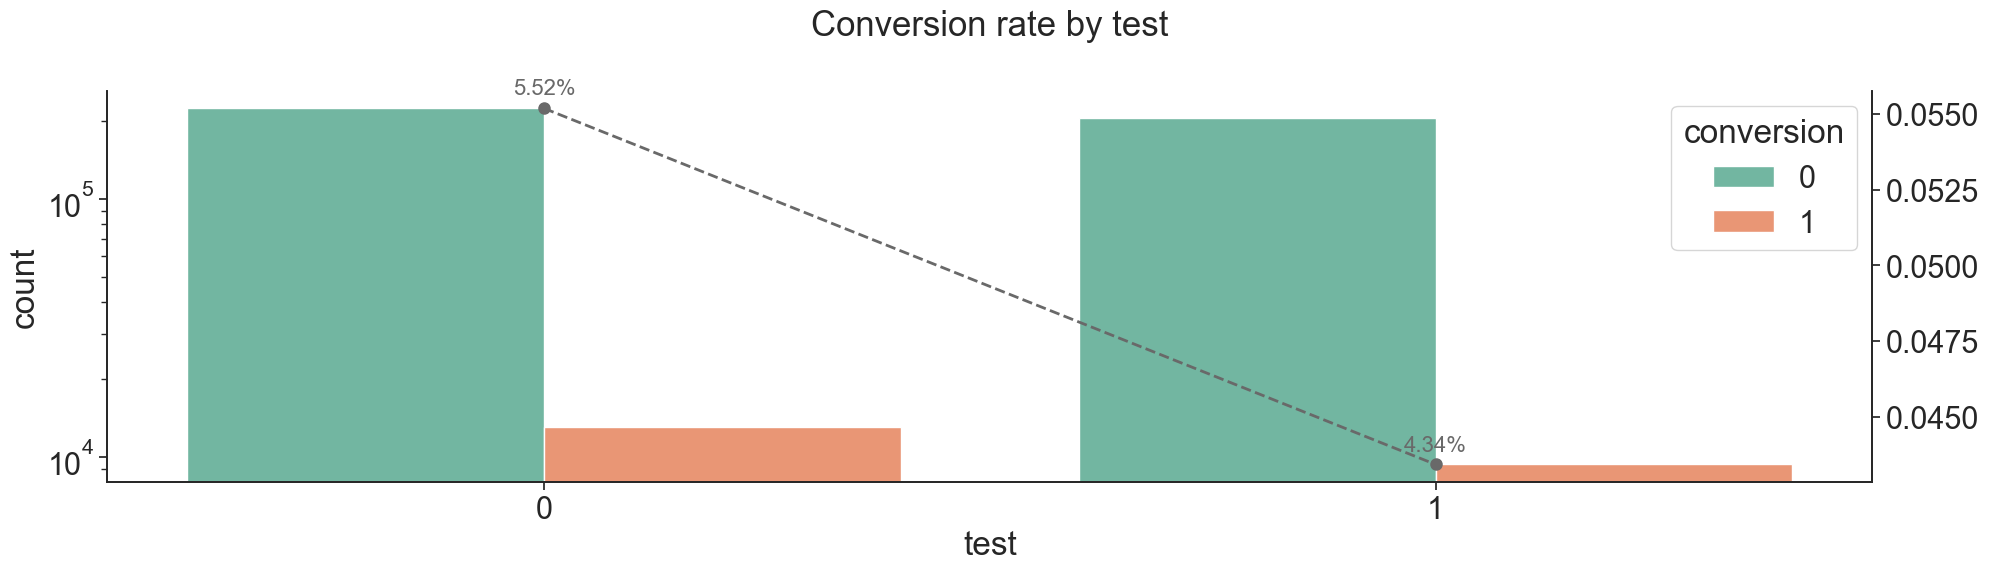

In [11]:
plot_conversion_rate_categorical(test_table, "test")

# Steps

## Assumption Check

To decide whether to use the parametric or nonparametric version of the test, we should check the specific requirements listed below:

- Observations in each sample are independent and identically distributed (IID).
- Observations in each sample are normally distributed.
- Observations in each sample have the same variance.

In [14]:
test_table.groupby(["test", "conversion"]).count()

user_id    date  source  device  browser_language  \
test conversion                                                      
0    0            224242  224242  224242  224242            224242   
     1             13096   13096   13096   13096             13096   
1    0            206604  206604  206604  206604            206604   
     1              9379    9379    9379    9379              9379   

                 ads_channel  browser  
test conversion                        
0    0                 90058   224242  
     1                  5290    13096  
1    0                 82761   206604  
     1                  3768     9379

In [15]:
## Check if there are users appearing in both groups

session_counts = test_table['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 0 users that appear multiple times in the dataset


In [17]:
import numpy as np
import scipy.stats as stats

conversion_rates = test_table.groupby('test')['conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
test,,,
0,0.055,0.228,0.000
1,0.043,0.204,0.000


In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = test_table[test_table['test'] == 0]['conversion']
treatment_results = test_table[test_table['test'] == 1]['conversion']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 18.21
p-value: 0.000
ci 95% for control group: [0.054, 0.056]
ci 95% for treatment group: [0.043, 0.044]


There are too many reasons other than translation. Users are from all over the world and have different backgrounds.

In [49]:
def plot_bar_plot(data, target):
    
    df = data.groupby(["test", target])["user_id"].agg("nunique").reset_index()
    
    plt.figure(figsize=(20,5))
    sns.catplot(x = target, y='user_id', 
                hue = 'test', data=df, 
                kind='bar',
                height=10, aspect=20/10)

In [58]:
data.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age',
       'country'],
      dtype='object')

<Figure size 2000x500 with 0 Axes>

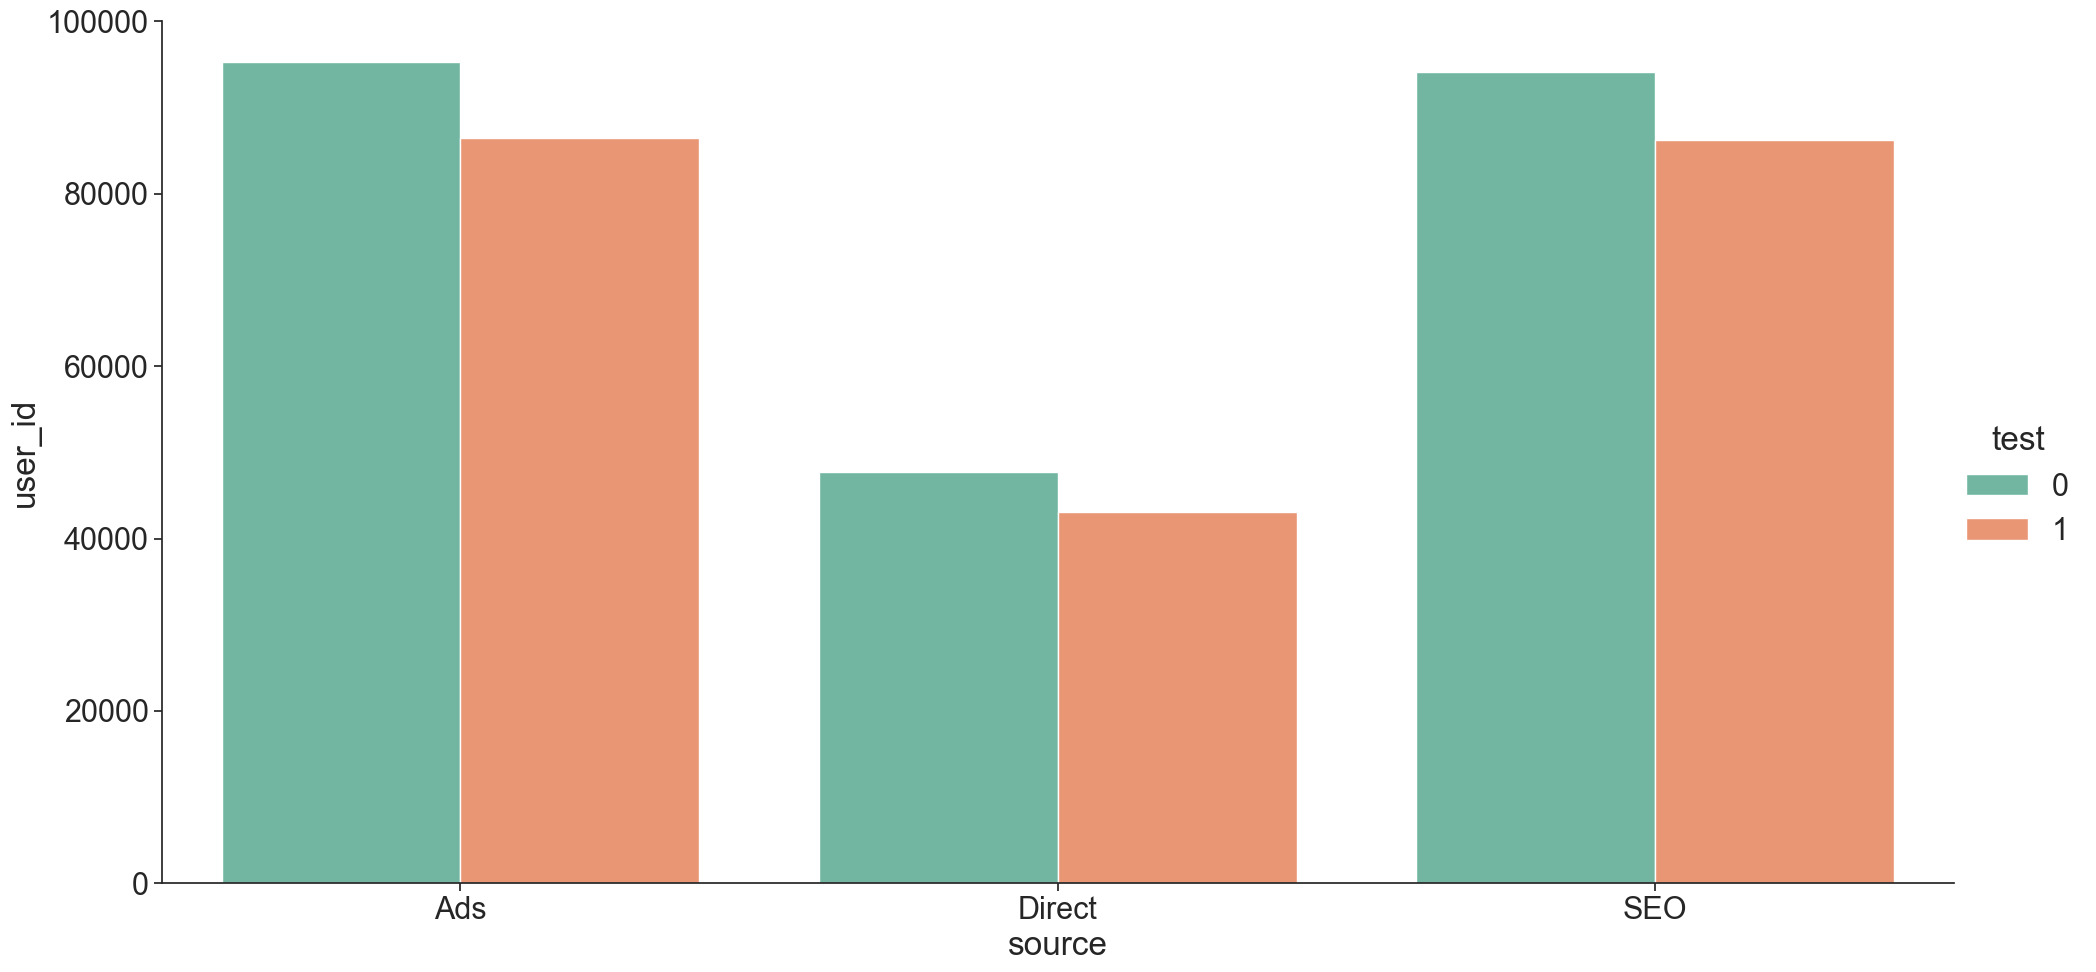

<Figure size 2000x500 with 0 Axes>

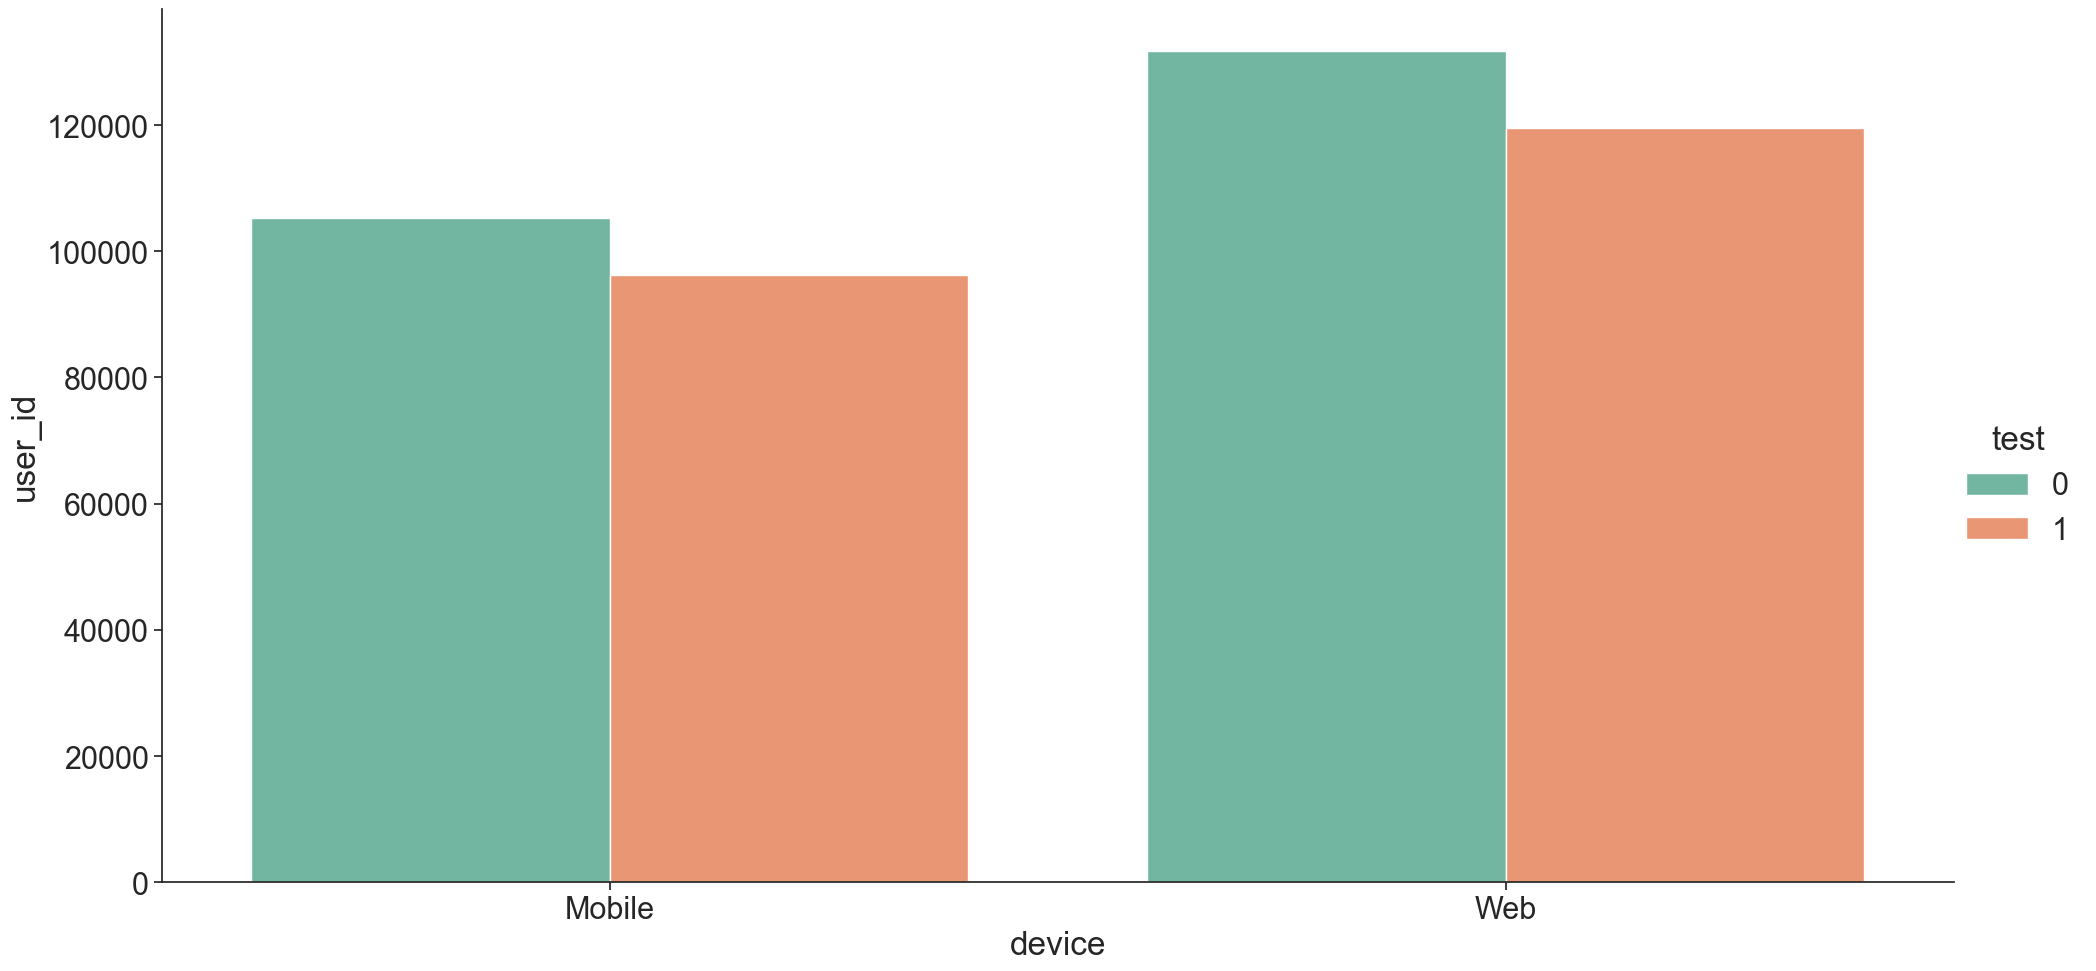

<Figure size 2000x500 with 0 Axes>

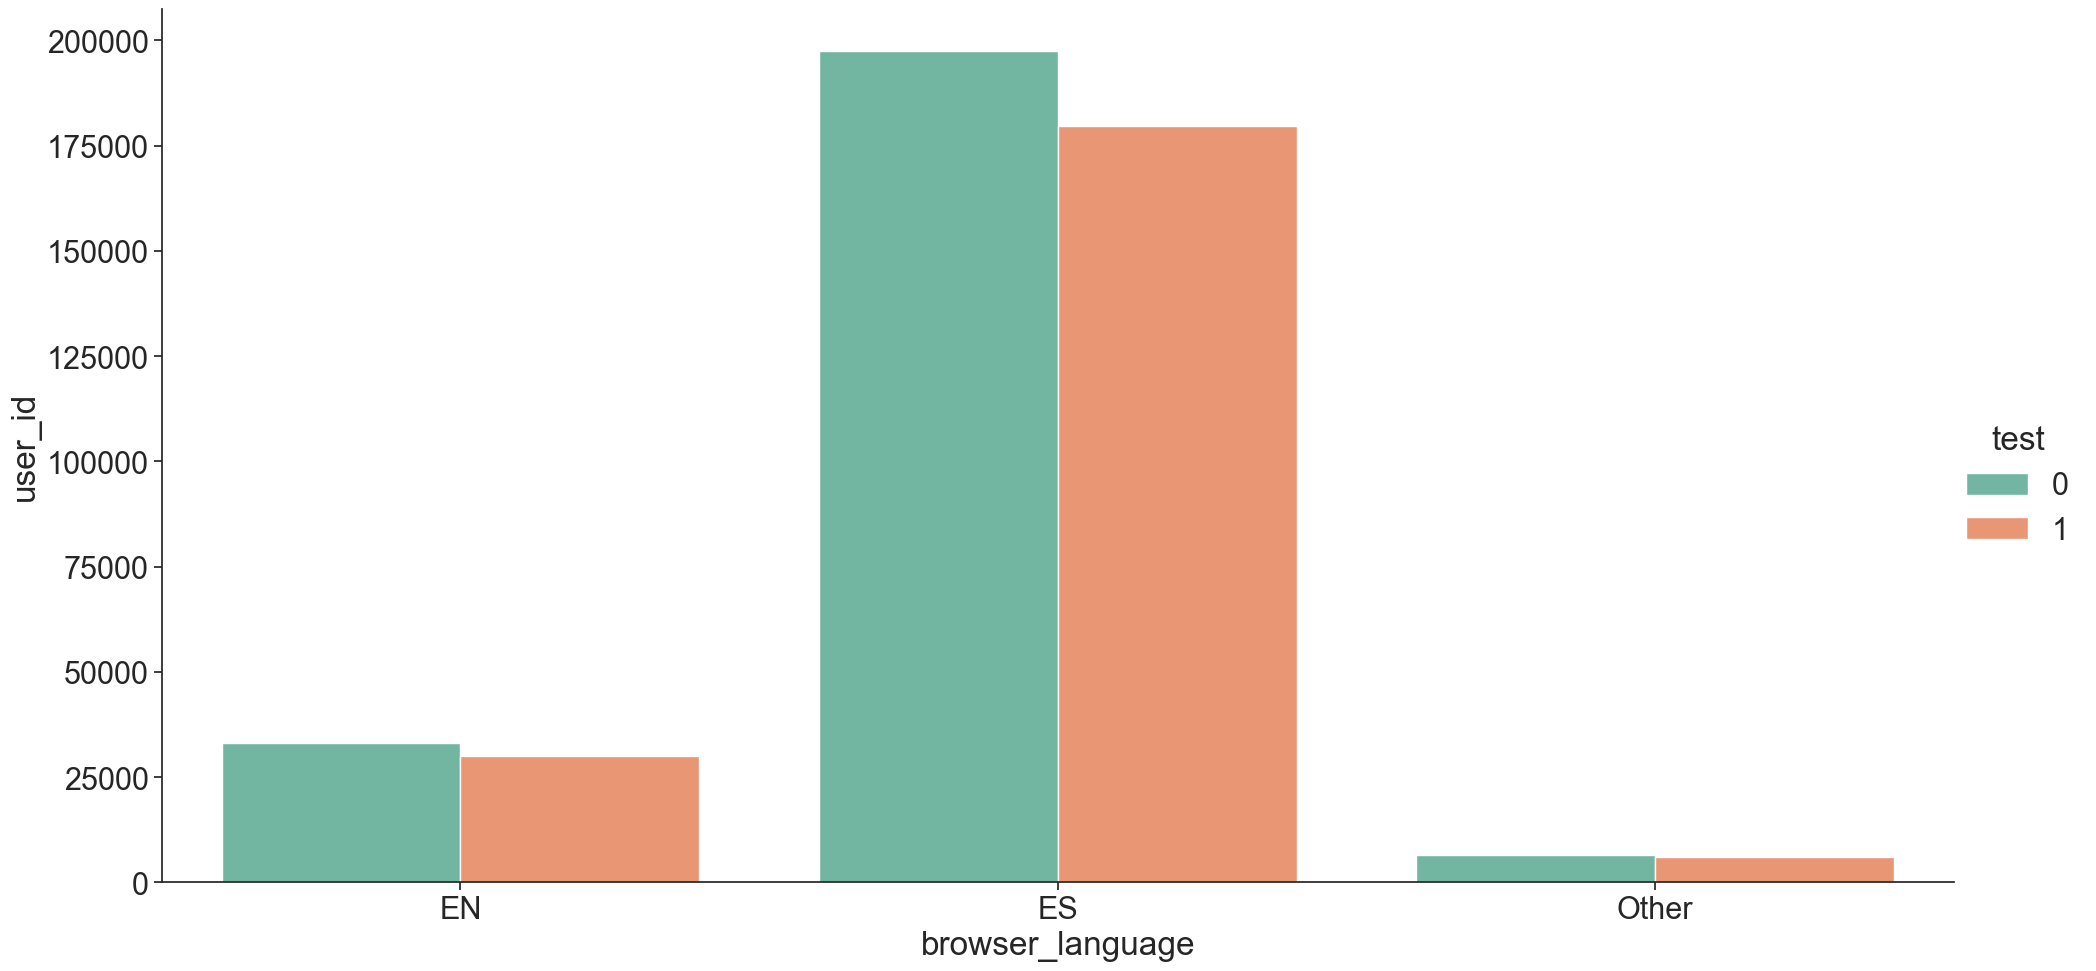

<Figure size 2000x500 with 0 Axes>

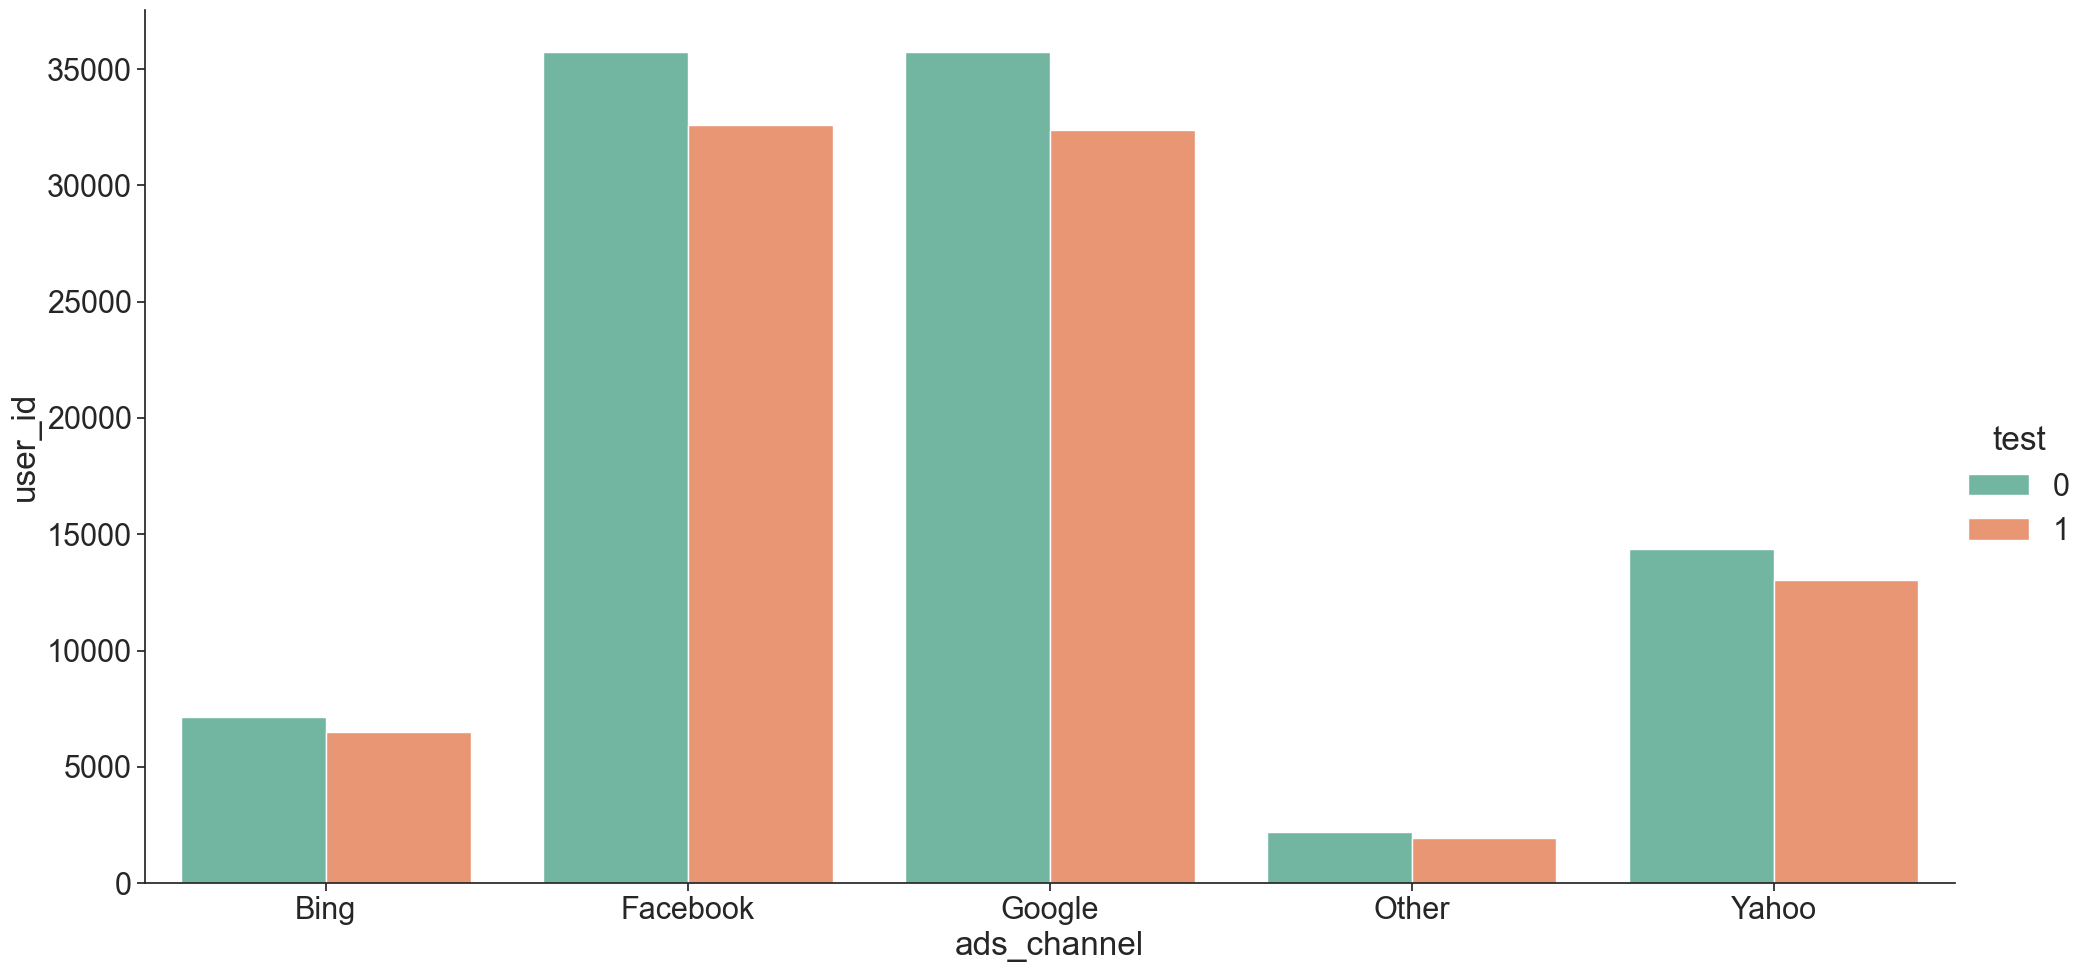

<Figure size 2000x500 with 0 Axes>

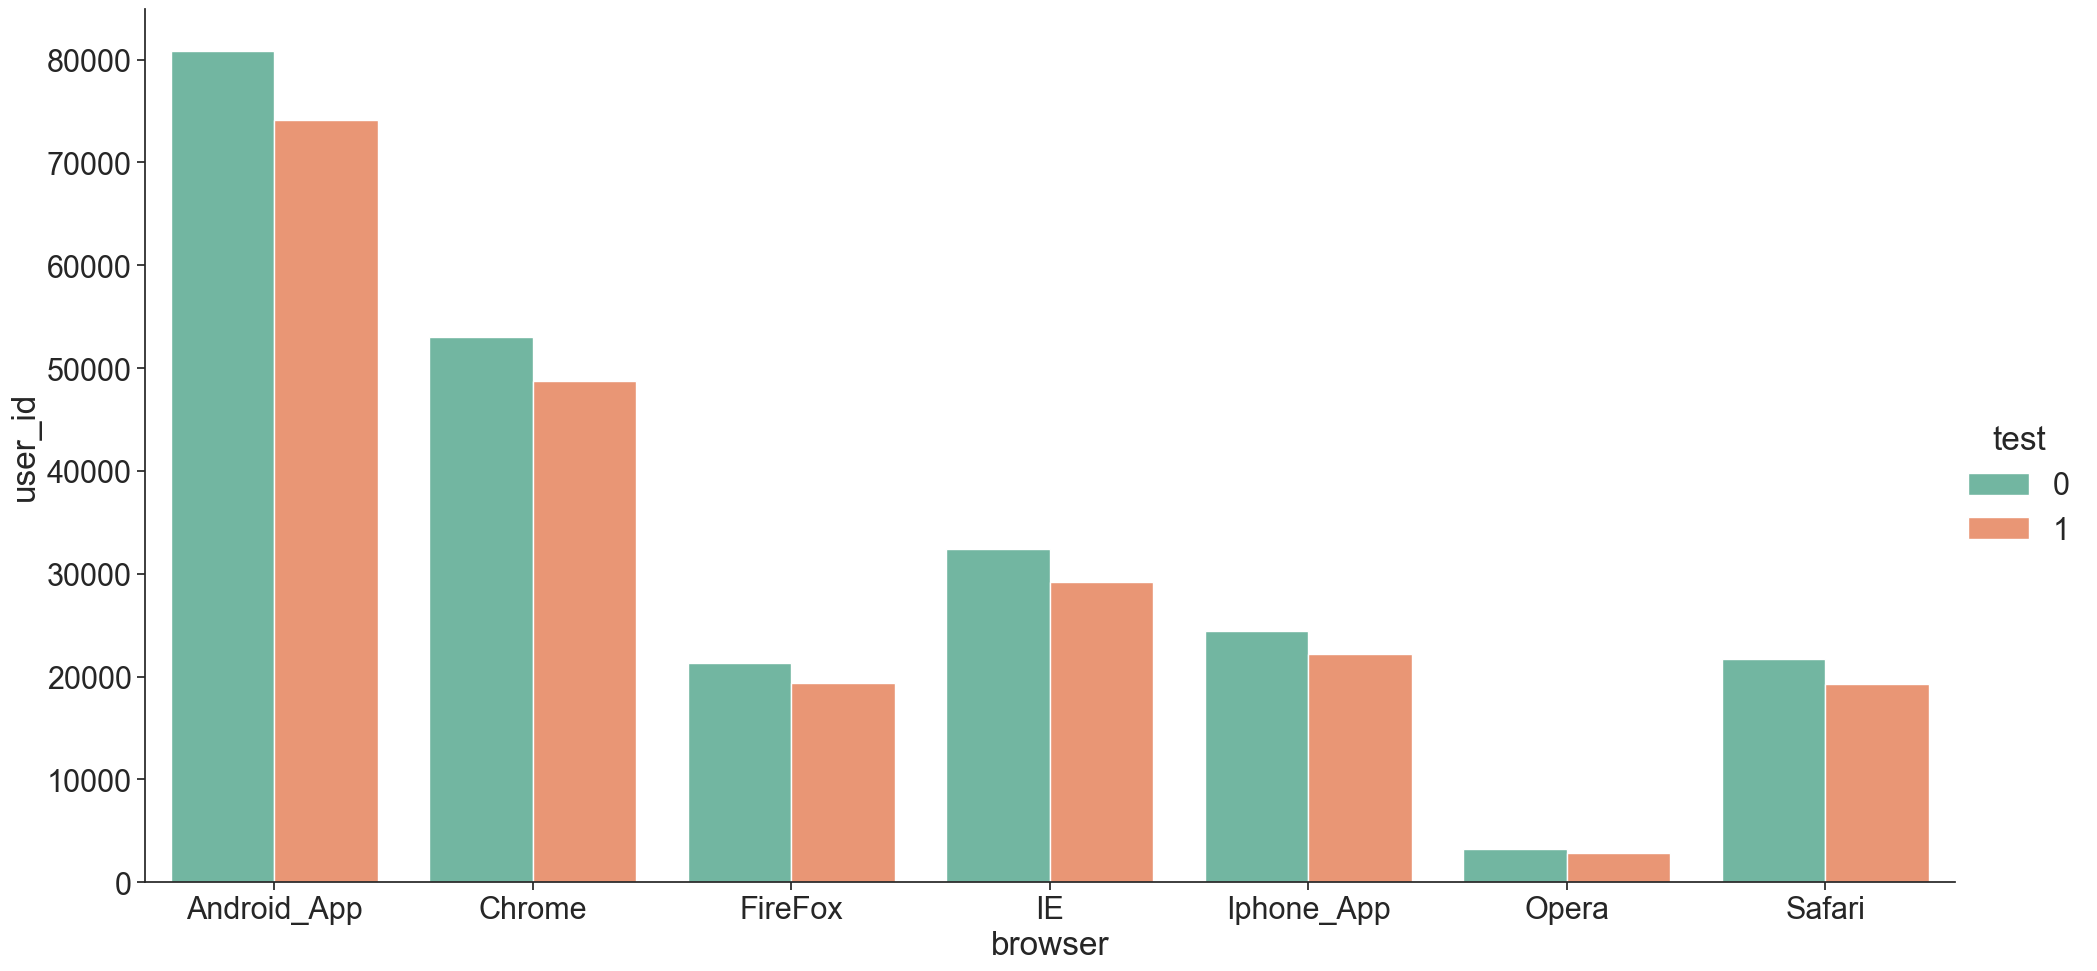

<Figure size 2000x500 with 0 Axes>

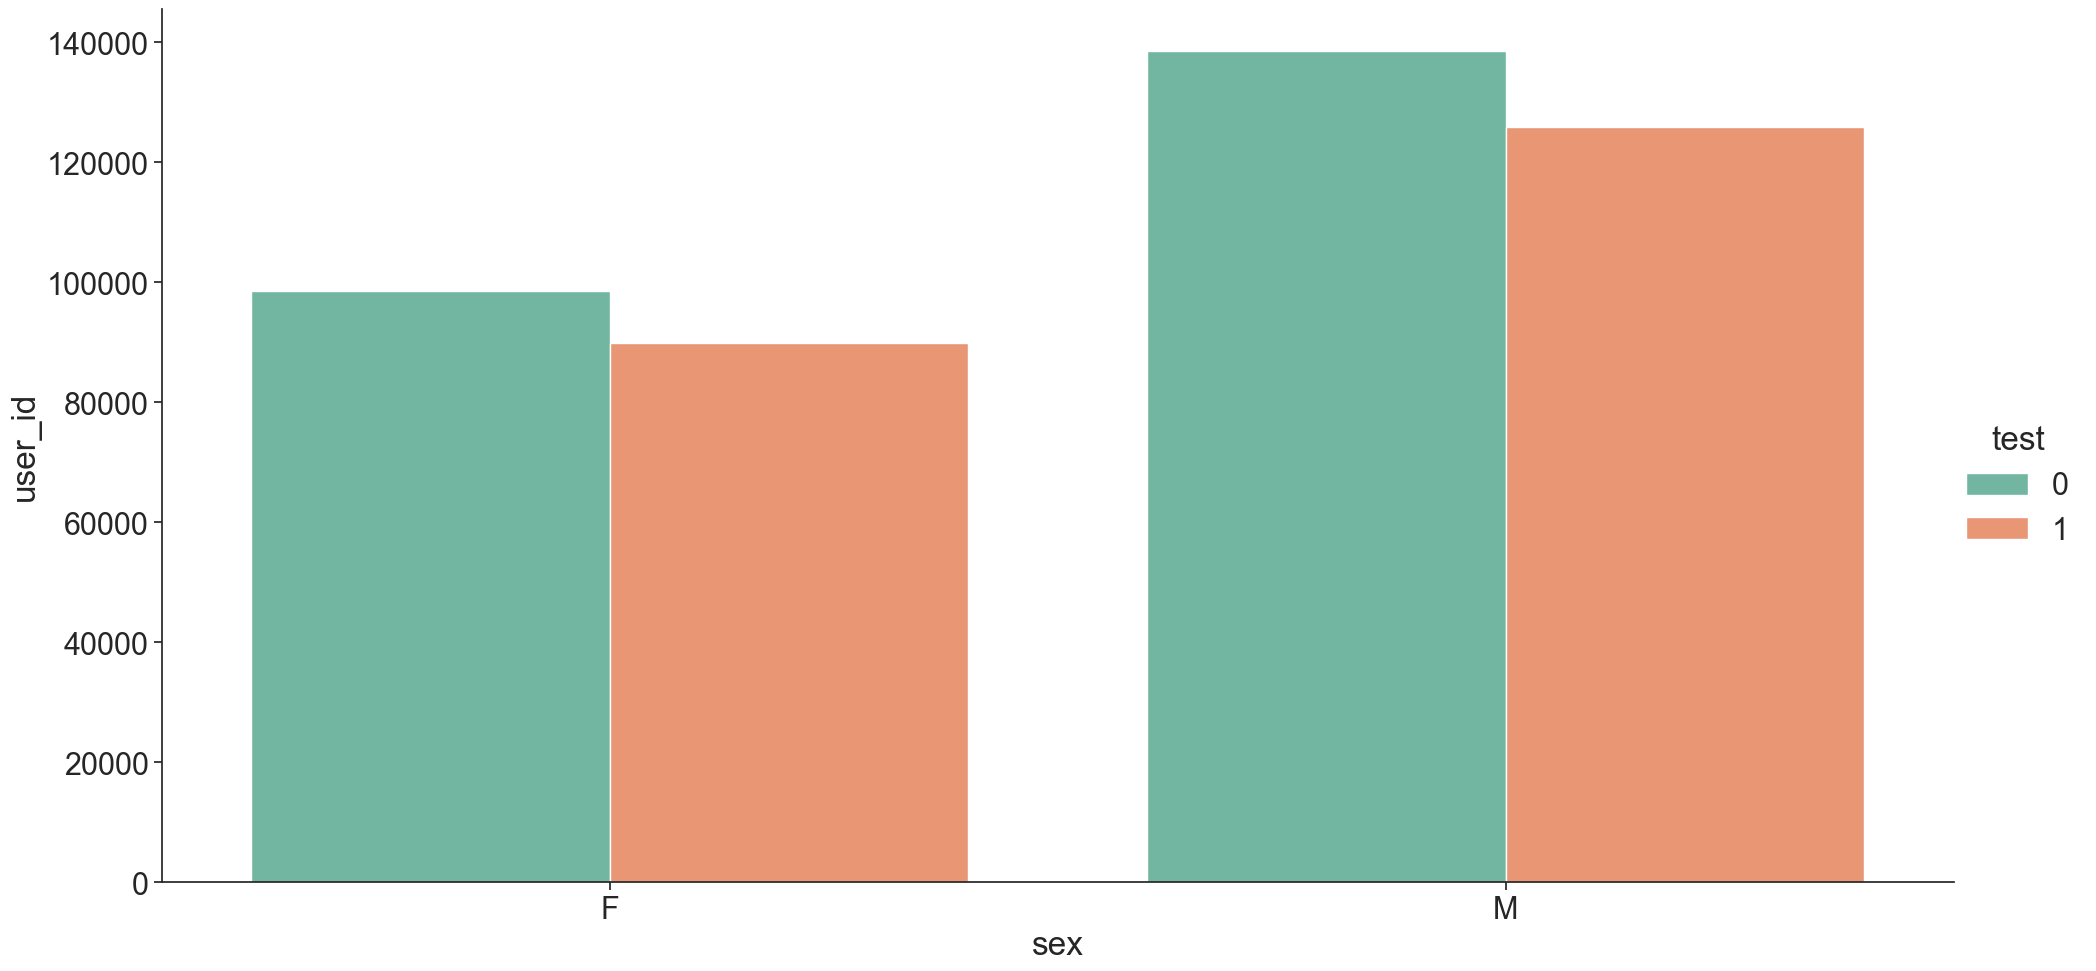

<Figure size 2000x500 with 0 Axes>

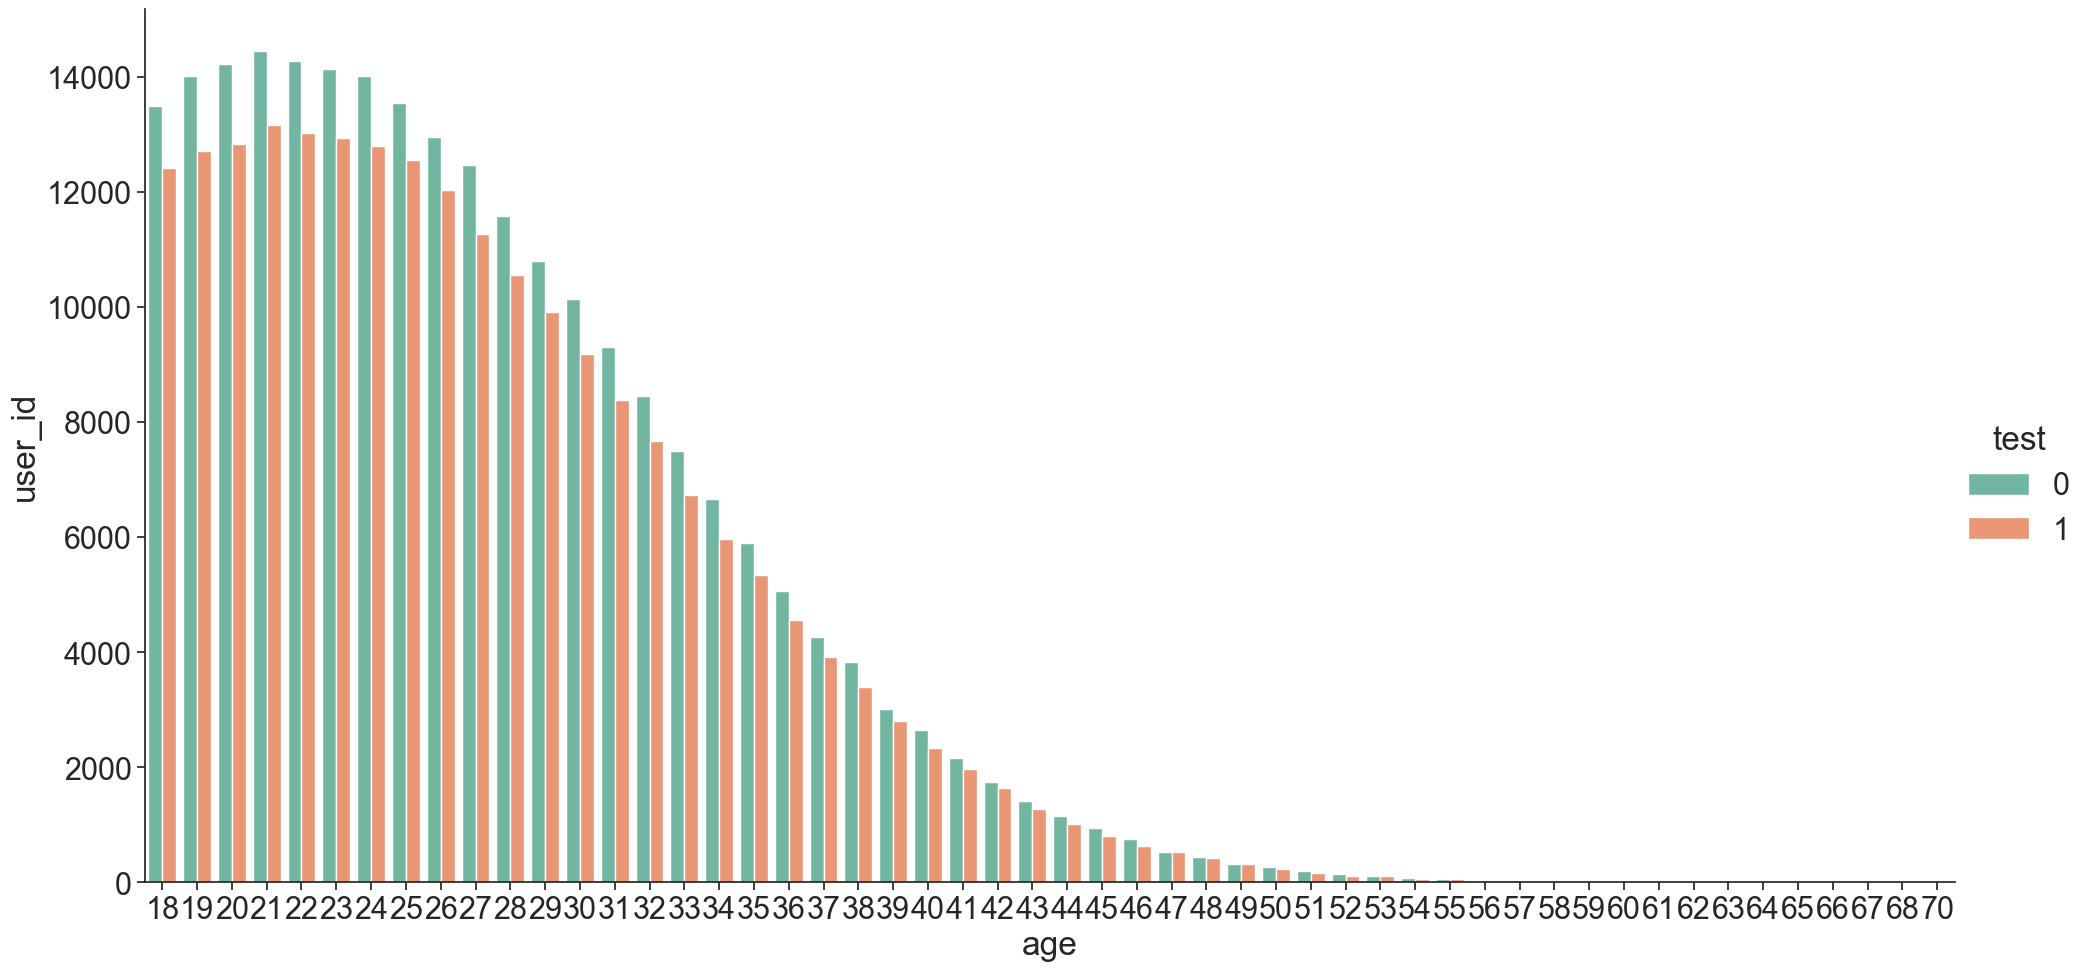

<Figure size 2000x500 with 0 Axes>

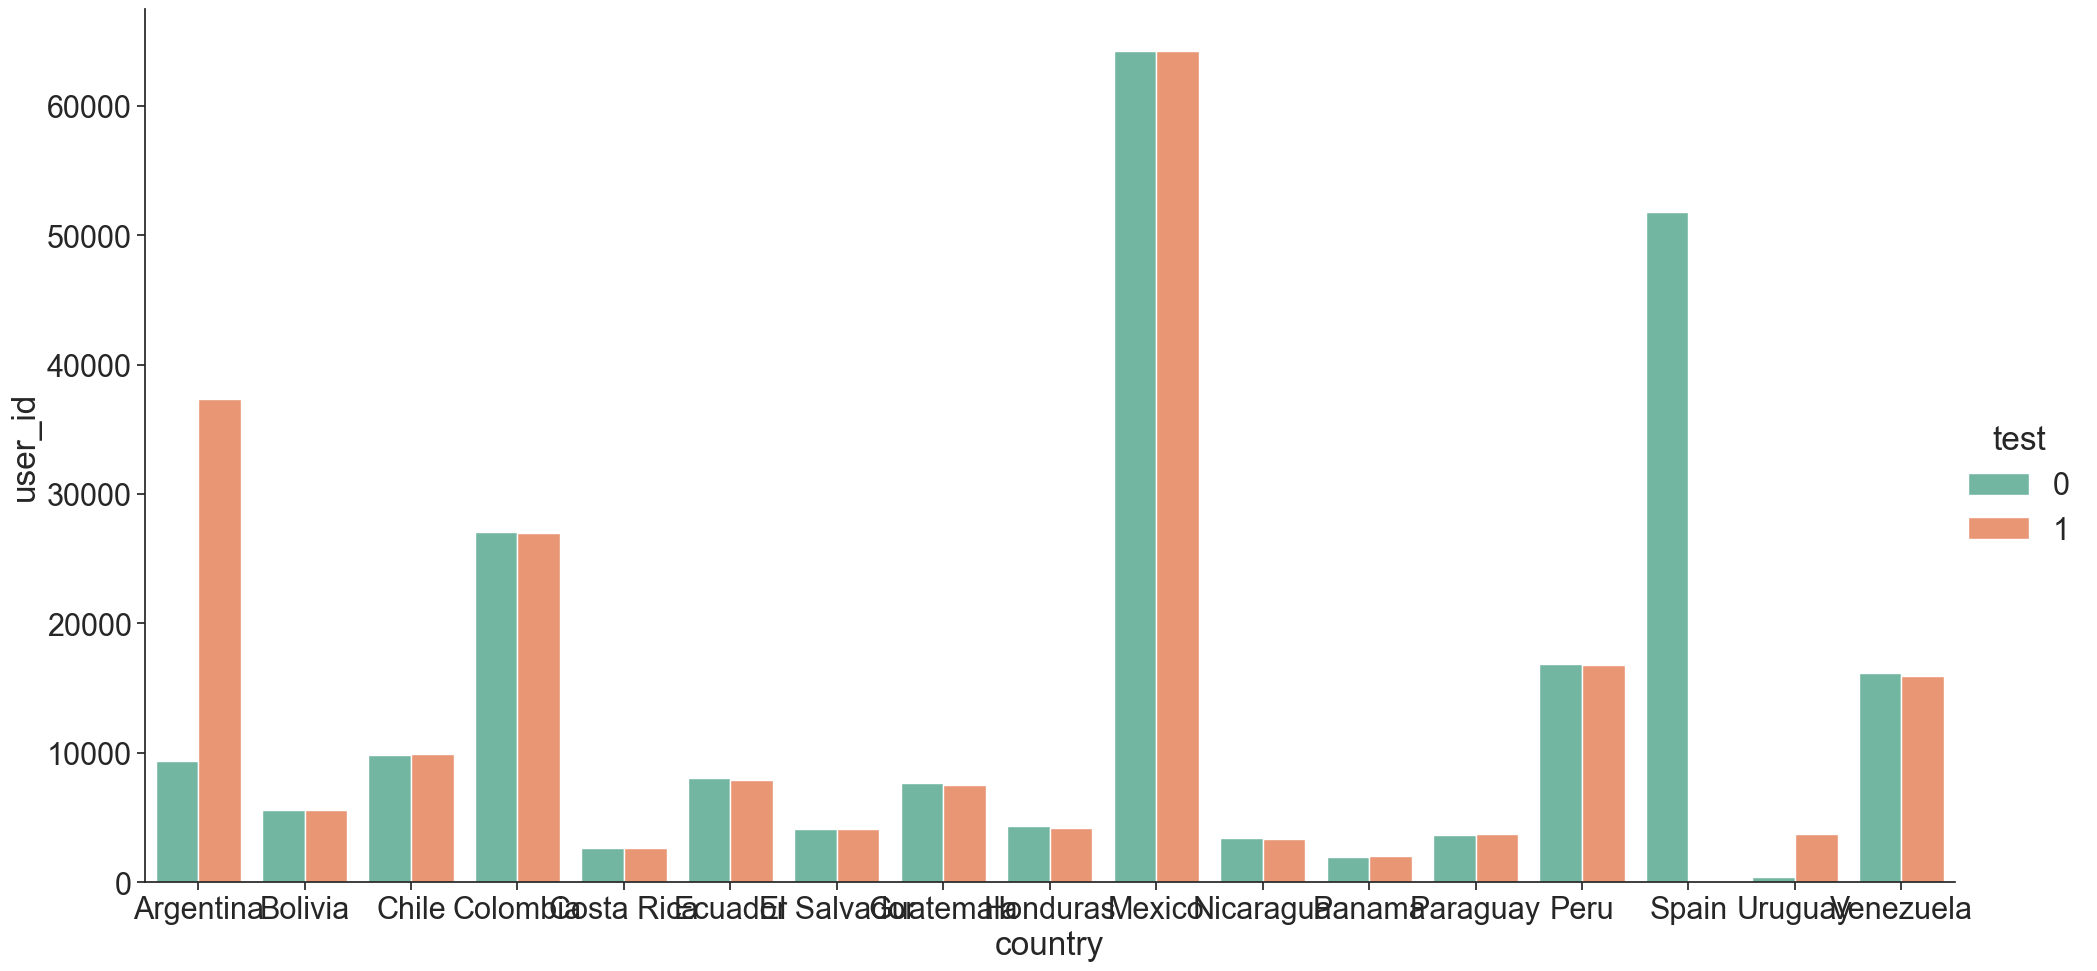

In [59]:
cols = ['source', 'device', 'browser_language', 'ads_channel', 'browser', 'sex', 'age', 'country']

# fig, axes = plt.subplots(5, figsize=(20, 10))

for i in range(len(cols)):
    plot_bar_plot(data, cols[i])

In [ ]:
countries = data[]

# Reference

1. https://towardsdatascience.com/hypothesis-testing-with-python-step-by-step-hands-on-tutorial-with-practical-examples-e805975ea96e
2. https://towardsdatascience.com/ab-testing-with-python-e5964dd66143

In [27]:
df

,test,source,user_id
0,0,Ads,95348
1,0,Direct,47740
2,0,SEO,94250
3,1,Ads,86529
4,1,Direct,43094
5,1,SEO,86360
